# Advanced Optimization: Assignment 2

Simon Schmetz

The following document contains the work done for the second Assignment in the course of advanced optimization in the Master of Statistics for Data Science. 

In [1]:
# Imports
import pandas as pd

import numpy as np
import gurobipy as gp
from gurobipy import GRB

from graphviz import Digraph


import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from graphviz import Digraph

from IPython.display import Image, display

from sklearn.metrics import accuracy_score



# Problem 1

The first problem set is performed in the context of optimization in machine learning, more specifically in the context of classification tasks. The dataset used is the famous wine dataset (https://archive.ics.uci.edu/dataset/109/wine), which contains 178 datapoints corresponding to one of three categories of wines and a range of continious variables for each wine. The following pice of codes imports the dataset from sklearn and seperately generates a dataframe for later use.

In [2]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target
target_names = data.target_names  

# Create DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['target_name'] = pd.Series(data.target).map(dict(enumerate(data.target_names)))


## a) Classes 1 and 2 linealy separable ? 

__Task:__ Are classes 1 and 2 linearly separable based on all the features? Use the optimization
approach seen in class with Gurobi–Python to find out and discuss the results.

To check if classes 1 and 2 are linealy seperable, we first generate a subset of data corresponding to only wines from category 1 and 2.

In [3]:
# Format Subset of Data
df_classes_1_2 = df[df['target'].isin([0, 1])]

X_classes_1_2 = df_classes_1_2.drop(columns=['target', 'target_name']).values

y_classes_1_2 = df_classes_1_2['target'].values
y_classes_1_2 = np.where(y_classes_1_2 == 0, -1, 1) 



We then proceed using a perceptron to check if the classes are linealy separable. If a solution exists for the perceptron, we know the classes are indeed linearly separable. A way to proove that is by formulating the dual of the problem and checking if it is bounded, then the primal is feasible and the first two classes linealy separable. 

As implemented below, the dual formulation yields a solution. __The first two classes are thus linealy separable.__

In [4]:
### Perceptron Dual Formulation
n = X_classes_1_2.shape[0]

model = gp.Model("perceptron_dual")
mu_perceptron = model.addVars(n, lb=0, name="mu_perceptron")

model.setObjective(gp.quicksum(mu_perceptron[i] for i in range(n)), GRB.MAXIMIZE)

model.addConstrs((mu_perceptron[i] >= 0 for i in range(n)), name="non-negativity")
model.addConstrs((gp.quicksum(mu_perceptron[i] * y_classes_1_2[i] * X_classes_1_2[i, j] 
                              for i in range(n)) == 0 
                              for j in range(X_classes_1_2.shape[1])), name="constraint")
model.addConstr(gp.quicksum(mu_perceptron[i] * y_classes_1_2[i] for i in range(n)) == 0, name="constraint_sum")

model.setParam('OutputFlag', 0)
model.optimize()


# Get model status
status_dict = {
    GRB.OPTIMAL: "Optimal solution found.",
    GRB.UNBOUNDED: "The problem is unbounded.",
    GRB.INFEASIBLE: "The problem is infeasible.",
}
print("Model Status:", status_dict.get(model.Status, f"Unknown status code: {model.Status}"))



Set parameter Username
Set parameter LicenseID to value 2657021
Academic license - for non-commercial use only - expires 2026-04-26
Model Status: Optimal solution found.


## b) Hard Margin Classifier

__Task:__ If classes 1 and 2 are linearly separable, find an optimal hard-margin linear classifier.
Otherwise, find both an optimal soft-margin linear classifier and an optimal nonlinear
kernel classifier. Use Gurobi–Python optimization models and discuss the results.

As we found the data to be linealy separable in a), we proceed with a hard margine classifier (Hard Margine Support Vector Machine) to find a optimal linear seperation between the two classes. The implementation below is a modified version of the dual SVM as implemented in class. 

In [5]:
"""
Based on the script orginally Created on Fri Apr 11 17:13:32 2025 by @author: josenino-mora
"""

# Model
model = gp.Model("svm_dual")
mu = model.addVars(n, lb=0.0, name="mu")

K = X_classes_1_2 @ X_classes_1_2.T 
Q = np.outer(y_classes_1_2, y_classes_1_2) * K

# Obj. - max sum(mu_i) - 0.5 * sum_{i,j} mu_i mu_j y_i y_j <x_i, x_j>
model.setObjective(
    gp.quicksum(mu[i] for i in range(n)) -
    0.5 * gp.quicksum(Q[i, j] * mu[i] * mu[j] for i in range(n) for j in range(n)),
    GRB.MAXIMIZE
)

# Constr - sum(mu_i * y_i) = 0
model.addConstr(gp.quicksum(mu[i] * y_classes_1_2[i] for i in range(n)) == 0, name="equality")

model.setParam('OutputFlag', 0)
model.optimize()

With the solution, we can then perform classification on the training data for a quick sanity check to validate the results. By working back from the dual probelm and generating the predictions, we yield a 100% accuracy, showing that our SVM is as expected able to perfectly seperate the data for wine classes 1 and 2.

In [6]:
# get weights and biases
mu_vals = np.array([mu[i].X for i in range(n)])
w = np.sum((mu_vals * y_classes_1_2)[:, None] * X_classes_1_2, axis=0) 


support_idx = np.where(mu_vals > 1e-6)[0][0]
x_s = X_classes_1_2[support_idx]
y_s = y_classes_1_2[support_idx]

b = y_s - np.dot(w, x_s)

# make predictions
def predict(X_test):
    return np.sign(X_test @ w + b)
y_pred = predict(X_classes_1_2)

# get accuracy
accuracy = accuracy_score(y_classes_1_2, y_pred)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 100.00%


## c) Optimal Classifier Tree

__Task:__ Adapt the codes seen in class to construct OCTs for the three classes with axis-parallel
splits based on the first two features. Construct OCTs up to the maximum depth that
your computer can solve within a reasonably short time. Discuss the results.

Moving on to classification trees, we again use code once used in class to generate a optimal classification tree, this time for all three classes. We now train a tree of depth two (more than two not feasible, potentially due to n_depth > n_features) as shown below.

In [7]:
"""
Based on the script orginally Created on Thu Apr 24 22:51:51 2025 by @author: josenino-mora
"""
# 
X = X[:, :2]

n_samples, n_features = X.shape
classes = [0, 1, 2]


# Tree depth
depth = 2
n_internal = 2**depth - 1
n_leaves = 2**depth

# Big-M constant
M = np.max(X) - np.min(X)
eps = 1e-4

# Create model
m = gp.Model("OCT_depth3")
#m.setParam('OutputFlag', 0)

# Split selection: s[j,t] = 1 if node t splits on feature j
s = m.addVars(n_features, n_internal, vtype=GRB.BINARY, name="s")
# Thresholds for each internal node
t = m.addVars(n_internal, vtype=GRB.CONTINUOUS, name="b")
# Routing: l[i,k] = 1 if sample i assigned to leaf k
l = m.addVars(n_samples, n_leaves, vtype=GRB.BINARY, name="l")
# Class assignment at leaves: z[k,c]
z = m.addVars(n_leaves, classes, vtype=GRB.BINARY, name="z")
# Misclassification loss
loss = m.addVars(n_samples, vtype=GRB.BINARY, name="loss")

# Each sample assigned to exactly one leaf
for i in range(n_samples):
    m.addConstr(gp.quicksum(l[i, k] for k in range(n_leaves)) == 1)

# Each leaf predicts exactly one class
for k in range(n_leaves):
    m.addConstr(gp.quicksum(z[k, c] for c in classes) == 1)

# Feature selection: one feature per internal node
for t_idx in range(n_internal):
    m.addConstr(gp.quicksum(s[j, t_idx] for j in range(n_features)) == 1)

# Routing constraints: for each sample, leaf, and internal node
# Precompute direction of leaf k at node t: -1=left, +1=right
direction = np.zeros((n_leaves, n_internal), dtype=int)
for k in range(n_leaves):
    node = n_internal + k  # full-tree index of leaf
    # walk up to root
    while node > 0:
        parent = (node - 1) // 2
        if node == 2 * parent + 1:
            direction[k, parent] = -1
        else:
            direction[k, parent] = 1
        node = parent

for i in range(n_samples):
    # misclassification constraints
    for k in range(n_leaves):
        for c in classes:
            if c != y[i]:
                m.addConstr(loss[i] >= l[i, k] + z[k, c] - 1)
    # routing by splits
    for t_idx in range(n_internal):
        expr = gp.quicksum(s[j, t_idx] * X[i, j] for j in range(n_features))
        # for each leaf k, enforce this for l[i,k]
        for k in range(n_leaves):
            if direction[k, t_idx] == -1:
                m.addConstr(expr <= t[t_idx] + M * (1 - l[i, k]))
            elif direction[k, t_idx] == 1:
                m.addConstr(expr >= t[t_idx] + eps - M * (1 - l[i, k]))

# Objective: minimize misclassification
m.setObjective(gp.quicksum(loss[i] for i in range(n_samples)), GRB.MINIMIZE)

# Solve
m.setParam('OutputFlag', 0)
m.optimize()


## Extract solution
# Splits: feature and threshold
splits = []
for t_idx in range(n_internal):
    feat = np.argmax([s[j, t_idx].X for j in range(n_features)])
    thresh = t[t_idx].X
    splits.append((feat, thresh))
# Leaf predictions\
    leaf_preds = [np.argmax([z[k, c].X for c in classes]) for k in range(n_leaves)]

From the training, we yield the tree shown in the plot below. Interpretation remains dificult, with the only insight being that dependent on x1, the threshhold for a datapoint belonging to Class 1 shifting slightly.

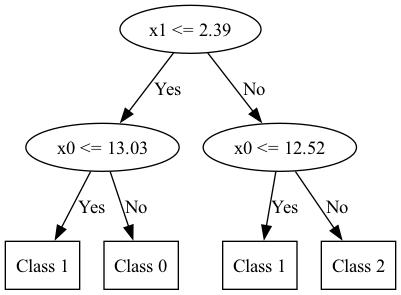

In [8]:

### Plot tree with Graphviz
g = Digraph('OCT', format='png')
def node_name(idx):
    return f"N{idx}"

# Add internal nodes
for t_idx, (feat, thresh) in enumerate(splits):
    g.node(node_name(t_idx), f"x{feat} <= {thresh:.2f}")
# Add leaves
for k, pred in enumerate(leaf_preds):
    leaf_idx = n_internal + k
    g.node(node_name(leaf_idx), f"Class {pred}", shape='box')
# Add edges
def add_edges(idx):
    left = 2*idx + 1
    right = 2*idx + 2
    if left < n_internal + n_leaves:
        g.edge(node_name(idx), node_name(left), label='Yes')
        add_edges(left)
    if right < n_internal + n_leaves:
        g.edge(node_name(idx), node_name(right), label='No')
        add_edges(right)
add_edges(0)

# Show plot
g.render('oct_depth3_tree', format='png', cleanup=True)
display(Image(filename='oct_depth3_tree.png'))

To evaluate the optimal depth of the tree, we perform prediction on the training data, with a resulting accuracy of 83.15%. With the results seemingly impressive for depth two, it can be assumed, that the accuracy can be significantly improved by using greater depth, as classes one and two have been found to be linealy separable. Allowing the tree to use more predictors could be an alternative approach to improve accuracy further, allowing the tree to pick the optimal features.

In [9]:
def predict_tree(X_test, splits, leaf_preds):
    n_internal = len(splits)
    n_leaves = len(leaf_preds)
    predictions = []

    
    for x in X_test:
        # walk through tree
        node = 0  
        while node < n_internal:
            feature, threshold = splits[node]
            if x[feature] <= threshold:
                node = 2 * node + 1 # go left
            else:
                node = 2 * node + 2  # go right
        leaf_index = node - n_internal
        predictions.append(leaf_preds[leaf_index])

    return np.array(predictions)

# Calculate accuracy
predictions = predict_tree(X, splits, leaf_preds)
accuracy = accuracy_score(y, predictions)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 83.15%


## d) OCT-H

__Task:__ Do as in part c) but for OCT-H.

To further improve the performance of our classification, we then proceed to using a Optimal classification tree with hyperplanes (OCT-H) to allow for linear combinations of multiple predictors. We again use the code shown in class.

In [10]:
"""
Based on the script orginally Created on Fri Apr 25 18:21:36 2025 by @author: josenino-mora
"""

n, d = X.shape

# Big-M and margin
M = 1e3
epsilon = 1e-4

# Create model
model = Model()
model.Params.OutputFlag = 0

# Node 1 (root) hyperplane: separate class 0 vs {1,2}
w1 = model.addVars(d, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="w1")
b1 = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name="b1")
# Node 2 (right child) hyperplane: separate class1 vs class2
w2 = model.addVars(d, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="w2")
b2 = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name="b2")

# Assignment and error vars
u = model.addVars(n, vtype=GRB.BINARY, name="go_right")  # root decision
v = model.addVars(n, vtype=GRB.BINARY, name="go_versicolor")  # second node decision
l = model.addVars(n, 3, vtype=GRB.BINARY, name="leaf_class")  # l[i,k]=1 if sample i assigned class k
e = model.addVars(n, vtype=GRB.BINARY, name="error")

# Constraints: each sample assigned exactly one leaf class
for i in range(n):
    model.addConstr(quicksum(l[i,k] for k in range(3)) == 1, name=f"oneclass_{i}")

# Link root decision u: u=1 if sample goes right (w1'x + b1 >= 0)
for i in range(n):
    expr1 = quicksum(w1[j]*X[i,j] for j in range(d)) + b1
    model.addConstr(expr1 + M*(1 - u[i]) >= 0, name=f"root_pos_{i}")
    model.addConstr(expr1 - M*u[i] <= 0, name=f"root_neg_{i}")

# Link second decision v only for those going right; left branch directly class 0
for i in range(n):
    expr2 = quicksum(w2[j]*X[i,j] for j in range(d)) + b2
    model.addConstr(expr2 + M*(1 - v[i]) >= epsilon - M*(1-u[i]), name=f"node2_pos_{i}")
    model.addConstr(expr2 - M*v[i] <= -epsilon + M*(1-u[i]), name=f"node2_neg_{i}")

# Link leaf_class l[i,k] to u and v
for i in range(n):
    model.addConstr(l[i,0] == 1 - u[i], name=f"leaf0_{i}")
    model.addConstr(l[i,1] == u[i]*v[i], name=f"leaf1_{i}")
    model.addConstr(l[i,2] == u[i]*(1-v[i]), name=f"leaf2_{i}")

# Error constraints: e[i]=1 if assigned class != true label
for i in range(n):
    for k in range(3):
        if k != int(y[i]):
            model.addConstr(e[i] >= l[i,k], name=f"err_{i}_{k}")

# Objective: minimize total errors
model.setObjective(quicksum(e[i] for i in range(n)), GRB.MINIMIZE)

model.setParam('OutputFlag', 0)
model.optimize()

# Extract solution values
w1_val = np.array([w1[j].X for j in range(d)])
b1_val = b1.X
w2_val = np.array([w2[j].X for j in range(d)])
b2_val = b2.X
l_val = np.array([[l[i,k].X for k in range(3)] for i in range(n)])
pred = l_val.argmax(axis=1)

Performing predictions on the training data for this classifier, we find an increase in predictive power relative to the base OCT, with this classifier yielding a 100% accuracy as shown below. 

In [11]:
# Calculate classification errors
classification_errors = np.sum(pred != y)
total_samples = len(y)
accuracy = 1-classification_errors / total_samples

print(f"Total Classification Errors: {classification_errors}")
print(f"Accuracy: {accuracy:.2%}")

Total Classification Errors: 0
Accuracy: 100.00%


However when reviewing the weigts and biases, we find all except of bias 2 to be zero, hinting at the fact that the code might contain errors. This might also explain the perfect accuracy, hinting at a potentially errorsome code.

In [12]:
print("w1 (root hyperplane weights):", w1_val)
print("b1 (root hyperplane bias):", b1_val)
print("w2 (right child hyperplane weights):", w2_val)
print("b2 (right child hyperplane bias):", b2_val)

w1 (root hyperplane weights): [0. 0.]
b1 (root hyperplane bias): 0.0
w2 (right child hyperplane weights): [0. 0.]
b2 (right child hyperplane bias): 0.00010000000111176632


## Conclusion Part 1

Overall, with the data seemingly well seperated, the resulting good accuracy results for all classifiers are not unexpected. Intereistingly, in the case of the OTC, depth 3 seems to be a minimum no in computation time, with solving times in creasing for both depth 2 and 4. Assuming the used code is indeed correct, OCT-H appear to be able to slightly represent the data better. Further review would however be required to make sure the results are correct.

# Problem 2

__Context:__ A company exploits a renewable resource (e.g., forestry, fish- eries, land, etc.). The resource level at the start of time period (year) t= 0,1,... is given by its state st, which can take the values 0,1,...,n: as the resource gets depleted, its state becomes lower. Thus, state 0 represents a completely depleted resource, and state n a full resource level. At the start of each year t, the company observes the state and then decides whether it will exploit the resource (active action: at = 1) or let it rest (passive action: at = 0) in that year. If the state is i and the resource is exploited, the company (i) earns a reward of Ri e in the year, with R>0; and (ii) incurs an operating cost of C e. If the resource is idled no rewards are earned nor costs are incurred in the year. The state at the start of the next year depends on whether the resource is exploited or rested in the current year. If it is exploited and the current state is i, the state changes from i to i−1 with probability (w.p.) µi, and stays at iw.p. 1−µi. If rested, the state changes from ito i+ 1 w.p. λ(n−i) and stays at i w.p. 1−λ(n−i).

## a) Formulate Problem 

__Task:__ Formulate the problem of finding a policy that maximizes the total expected discounted reward (with discount factor 0 <β <1) over an infinite planning horizon as a Markov decision process (MDP). State the elements of such an MDP.

We thus begin by formulating the problem in the form of a Markov decision process.

__Formulation:__

_Time Periods_ $t = 0,1,...,T$
_States (number of Recourses)_ s_t = 0,1,...,n 

_Action (exploit/rest)_ for $ t, \; a_t \in \mathcal{A}(s_t) = \{0,1\}$
($0$, if exploit, $1$ if rest)

_One period Reward_ $R^a(i)$ 

- $R^0(i) = 0$

- $R^1(i) = R*i-C$


_State Transition Probabilities_

for $a_t = 0$ (rest):  
- $P(s_{t+1} = i+1 \mid s_t = i, a_t = 0) = \lambda (n-i)$  
- $P(s_{t+1} = i \mid s_t = i, a_t = 0) = 1 - \lambda (n-i)$

for $a_t = 1$ (exploit):  
- $P(s_{t+1} = i-1 \mid s_t = i, a_t = 1) = \mu_i$  
- $P(s_{t+1} = i \mid s_t = i, a_t = 1) = 1 - \mu_i$  

_Discount Factor_
$ 0 < \beta < 1 $


_objective function (Expected total discounted reward (ETD))_

$ \text{max } \mathbb{E}^{\pi}_i \left[ \sum_{t=0}^{\infty} (r_t- C_t) \beta^t \right]
$


## b) Formulate Bellman Equation, reforumlate as LO problem and solve via Gurobi 

__Task:__ For the discounted and for the long-run average criterion, formulate the Bellman equations, reformulate them as LO problems, and solve them using Gurobi–Python in the case n= 4, λ= 0.2, µ= 0.15, R= 5 and C = 0.5 (for the discounted criterion use β ∈{0.2,0.4,0.6,0.8,0.9}), identifying the optimal policies in each case.

With the elements of the MDP established, we proceed to derive the Bellman Equations as done in Class. The general formulation of the Bellmann Equation is as follows 

$
\quad v^*(i) = \text{max}_{a \in A(i)} R^a(i) + \beta \sum_{j \in S} p^a(i, j) v^*(j), \quad i \in S
$

which by introducing the corresponding probabilities for our problem, corresponds to

$
v^*(i) = \text{max}
\begin{cases}
\beta \left[(\lambda (n-i)) v^*(i+1) + (1-\lambda (n-i)) v^*(i)\right] \hspace{1.5em} \text{for } a_t = 0 \\
(R i - C) + \beta \left[(\mu i) v^*(i-1) + (1-\mu i) v^*(i)\right] \hspace{1.5em} \text{for } a_t = 1
\end{cases}
$

taking into account both possible actions respecitvely. For the special cases $i=0,4$ we observe how the respective probability terms go to zero, thus preventing the state and reward to move out of bounds.


With the Bellman Equations defined, we proceed to reformulate it as a Linera Optimization problem as shown in class

Minimize $\sum_{i} p_0(j)v(j)$

s.t.

$v^*(i) - \beta*[(\lambda*(n-i))*v^*(i+1)+(1-\lambda*(n-i))*v^*(i)] \geq 0$ 

$v^*(i) - \beta*[(\mu * i)*v^*(i-1)+(1-\mu*i)*v^*(i)] \geq R*i-C$


with the state probability at $t_0$ as $p_0(j) = \frac{1}{5}$

With the problem thus fully defined, we can proceed to solving the problem using the codes provided in class. We first define the inputs in the first code chunk below and then proceed to solve in the second chunk for multiple $\beta$ values.

In [13]:

# States and actions
states = [0,1,2,3,4]
actions = [0, 1]
theta = 1e-6  # Convergence threshold
betas = [0.2, 0.4, 0.6, 0.8,0.9]  # Different discount factors
lmbda = 0.2

n = 4
mu = 0.15
Red = 5
C = 0.5

# Transition probabilities P[s][a][s']
P = {
    0: {
        0: [1 - lmbda * (n-0), lmbda * (n-0), 0, 0, 0],  
        1: [1, 0, 0, 0, 0],  
    },
    1: {
        0: [0, 1 - lmbda * (n-1), lmbda * (n-1), 0, 0],
        1: [mu * 1, 1 - mu * 1, 0, 0, 0],
    },
    2: {
        0: [0, 0, 1 - lmbda * (n-2), lmbda * (n-2), 0],
        1: [0, mu * 2, 1 - mu * 2, 0, 0],
    },
    3: {
        0: [0, 0, 0, 1 - lmbda * (n-3), lmbda * (n-3)],
        1: [0, 0, mu * 3, 1 - mu * 3, 0],
    },
    4: {
        0: [0, 0, 0, 0, 1],  
        1: [0, 0, 0, mu * 4, 1 - mu * 4],
    },
}

# Rewards R[s][a]
R = {
    0: {0: 0, 1: Red*0 - C},
    1: {0: 0, 1: Red*1 - C},
    2: {0: 0, 1: Red*2 - C},
    3: {0: 0, 1: Red*3 - C},
    4: {0: 0, 1: Red*4 - C}
}

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May  8 20:53:15 2025

@author: josenino-mora
"""

import gurobipy as gp
from gurobipy import GRB
import numpy as np
from collections import defaultdict

# Solve the LP for a list of discount factors (betas)
results = {}

for beta in betas:
    # Create Gurobi model
    model = gp.Model("mdp_lp")
    model.setParam('OutputFlag', 0)  # suppress solver output

    # Add variables V_s for each state s
    V = model.addVars(states, name="V", lb=-GRB.INFINITY)

    # Objective: minimize sum of V_s
    model.setObjective(gp.quicksum(V[s] for s in states), GRB.MINIMIZE)

    # Constraints: V[s] ≥ R[s][a] + beta ∑ P(s' | s, a) * V[s']
    for s in states:
        for a in actions:
            rhs = R[s][a] + beta * gp.quicksum(P[s][a][s_next] * V[s_next] for s_next in states)
            model.addConstr(V[s] >= rhs, name=f"c_{s}_{a}")

    # Solve
    model.optimize()

    # Extract optimal value function
    V_opt = {s: V[s].X for s in states}

    # Derive optimal policy by greedy action selection
    policy = {}
    for s in states:
        best_a = max(actions, key=lambda a: R[s][a] + beta * sum(P[s][a][s_next] * V_opt[s_next] for s_next in states))
        policy[s] = best_a

    results[beta] = {"V_opt": V_opt, "policy": policy}


We investigate the results by plotting visualizations of the Optimal Values (left) and the optimal action (right).

_The Optimal Values_ show the unsurprising pattern of an increase in reward with increase in state due to the multiplactive nature $state \times reward$ of the reward function. Furthermore, the Value increases with increasing $\beta$, as the future rewards gain value

_The Optimal Action_ for each state are exploitation for $\beta \leq 0.6$ for all states except 0, while for $\beta \geq 0.8$ exploitation only becomes optimal at state 2, showing again how long term rewards becoming more valuable changes the optimal policies. 

Both of these results are in line with our expectations, leading us to believe that they are credible.


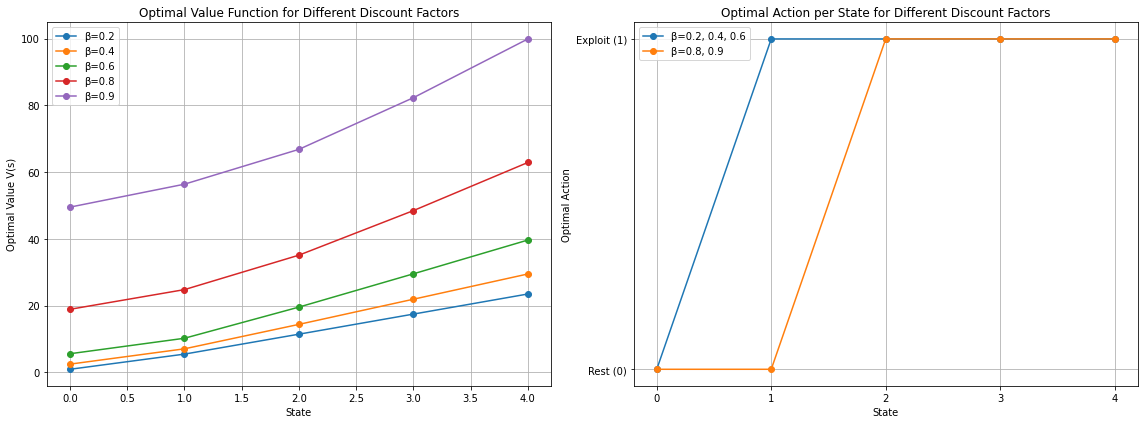

In [15]:
### PLOTS GENERATED WITH HELP OF GITHUB COPILOT


import matplotlib.pyplot as plt
# Plot optimal value functions and optimal policies side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Optimal value functions
for beta in betas:
    V_opt = results[beta]['V_opt']
    axes[0].plot(states, [V_opt[s] for s in states], marker='o', label=f"β={beta}")
axes[0].set_xlabel("State")
axes[0].set_ylabel("Optimal Value V(s)")
axes[0].set_title("Optimal Value Function for Different Discount Factors")
axes[0].legend()
axes[0].grid(True)


# Convert policy dicts to tuples for comparison
policy_groups = defaultdict(list)
for beta in betas:
    # tuple of actions for all states
    policy_tuple = tuple(results[beta]['policy'][s] for s in states)
    policy_groups[policy_tuple].append(beta)

# Plot each unique policy only once, with all corresponding betas in the label
for policy_tuple, beta_group in policy_groups.items():
    actions_plot = list(policy_tuple)
    label = "β=" + ", ".join(str(b) for b in beta_group)
    axes[1].plot(states, actions_plot, marker='o', label=label)
axes[1].set_xlabel("State")
axes[1].set_ylabel("Optimal Action")
axes[1].set_title("Optimal Action per State for Different Discount Factors")
axes[1].set_yticks([0, 1])
axes[1].set_xticks(states)
axes[1].set_yticklabels(["Rest (0)", "Exploit (1)"])
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Using the optimal policies, we can now simulate a random process, like the one below starting at $s=0$ with $\beta = 0.8$. The resulting process shows the oscilation between states 1 and 2, in line with the plot above.

In [16]:
### Generated using GitHub Copilot

def simulate_mdp(policy, P, R, states, actions, start_state=0, n_steps=20, seed=42):
    np.random.seed(seed)
    state = start_state
    state_history = [state]
    action_history = []
    reward_history = []

    for _ in range(n_steps):
        action = policy[state]
        action_history.append(action)
        reward = R[state][action]
        reward_history.append(reward)
        # Sample next state according to transition probabilities
        next_state = np.random.choice(states, p=P[state][action])
        state_history.append(next_state)
        state = next_state

    return {
        "states": state_history,
        "actions": action_history,
        "rewards": reward_history
    }

# Example: simulate for beta=0.8
beta_sim = 0.8
sim_result = simulate_mdp(
    policy=results[beta_sim]['policy'],
    P=P,
    R=R,
    states=states,
    actions=actions,
    start_state=0,
    n_steps=30
)

print("States:", sim_result["states"])
print("Actions:", sim_result["actions"])
print("Rewards:", sim_result["rewards"])

States: [0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1]
Actions: [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Rewards: [0, 0, 9.5, 9.5, 9.5, 0, 0, 0, 9.5, 9.5, 9.5, 0, 9.5, 9.5, 0, 0, 0, 0, 9.5, 9.5, 0, 9.5, 0, 0, 0, 9.5, 9.5, 0, 9.5, 9.5]



## c) Define critical Value

__Task:__ Define C∗(i) as the critical value of C for which both actions (active and passive) are optimal in a given state i. Evaluate C∗(i) for each state i, both for the discounted criterion with β = 0.8, and for the long-run average criterion. Discuss the results.

We solve the discounted criterion by fixing beta to 0.8 and by iterating over $C$ with start value 0 with a given step size for increase in $C$ with a maximum iterations limit. Once the difference in expected returns between both action falls below a threshold theta_ckrit, the loop is stopped and the current $C$ value stored as critical Value $C^*$.

In [17]:

beta = 0.8
step_size = 0.01

theta_ckrit = 0.01
iter_max = 10000

C_crit = {}
C_crit_exp = {}

# Initialize action_values[0:4][0:1] with large random values
action_values = {}
for s in range(5):
    action_values[s] = {}
    for a in range(2):
        action_values[s][a] = np.random.uniform(1e3, 1e4)

for s_iter in states:
    i = 0
    C = 0.1
    C_crit_exp[s_iter] = []

    while abs(action_values[s_iter][0] - action_values[s_iter][1]) > theta_ckrit:
        i = i + 1
    
        R = {
            0: {0: 0, 1: Red*0 - C},
            1: {0: 0, 1: Red*1 - C},
            2: {0: 0, 1: Red*2 - C},
            3: {0: 0, 1: Red*3 - C},
            4: {0: 0, 1: Red*4 - C}
        }
        
        # Create Gurobi model
        model = gp.Model("mdp_lp")
        model.setParam('OutputFlag', 0)  # suppress solver output

        # Add variables V_s for each state s
        V = model.addVars(states, name="V", lb=-GRB.INFINITY)

        # Objective: minimize sum of V_s
        model.setObjective(gp.quicksum(V[s] for s in states), GRB.MINIMIZE)

        # Constraints: V[s] ≥ R[s][a] + beta ∑ P(s' | s, a) * V[s']
        for s in states:
            for a in actions:
                rhs = R[s][a] + beta * gp.quicksum(P[s][a][s_next] * V[s_next] for s_next in states)
                model.addConstr(V[s] >= rhs, name=f"c_{s}_{a}")

        # Solve
        model.optimize()

        # Extract optimal value function
        V_opt = {s: V[s].X for s in states}

        # Store value for both actions in each state
        action_values = {}
        for s in states:
            action_values[s] = {}
            for a in actions:
                action_values[s][a] = R[s][a] + beta * sum(P[s][a][s_next] * V_opt[s_next] for s_next in states)


        C_crit_exp[s_iter].append({
                "C": C,
                "action_0": action_values[s_iter][0],
                "action_1": action_values[s_iter][1]
            })
        
        if i > iter_max:
            C = None
            action_values[s_iter][a] = None
            break

        C = C+step_size

    # Use the last C value before the difference was less than threshold
    C_crit[s_iter] = C


When printing the results yielded, we find only states 2-4 having positive critical C values.

In [18]:
print("C_crit:", C_crit)

C_crit: {0: None, 1: None, 2: 5.159999999999934, 3: 12.619999999999775, 4: 19.990000000000325}


Plotting the results, shows that for the two first states, the critical C Values might be negative, which in the context of cost does not make sense practically. Apart from that, we see a increase in critical cost over states, which accounts for the increase in Reward with increasing state.

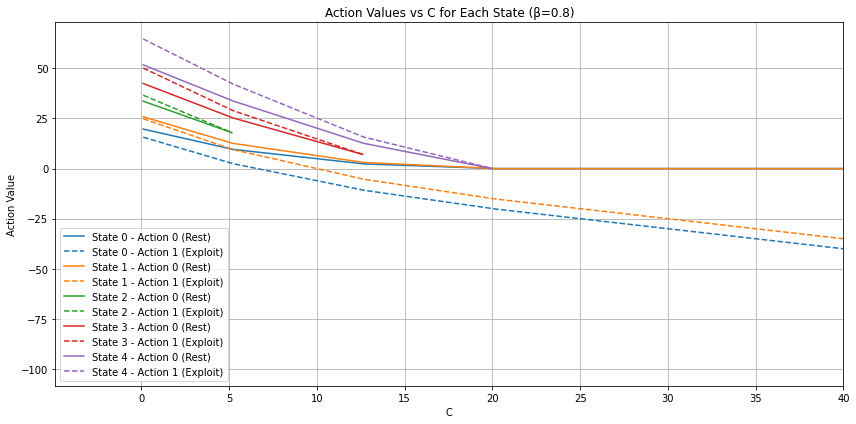

In [19]:
import matplotlib.pyplot as plt

# Plot action values for action 0 and 1 over C for each state
plt.figure(figsize=(12, 6))
for s in states:
    C_vals = [entry["C"] for entry in C_crit_exp[s]]
    action0_vals = [entry["action_0"] for entry in C_crit_exp[s]]
    action1_vals = [entry["action_1"] for entry in C_crit_exp[s]]

    color = f"C{s}" 
    plt.plot(C_vals, action0_vals, label=f"State {s} - Action 0 (Rest)", color=color)
    plt.plot(C_vals, action1_vals, label=f"State {s} - Action 1 (Exploit)", linestyle='--', color=color)

plt.xlabel("C")
plt.ylabel("Action Value")
plt.title("Action Values vs C for Each State (β=0.8)")

plt.xlim(right=40)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Unfortunately, the long run average criterion could not be evaluated due to time constraints.

## Conclusion Part 2

Overal, applying Markov Decision Processes yielded a sophisticated way to design decision policies maximizing the expected reward. They are however framework that requires some getting used to and thus some further investigation into the topic is needed to gain a deeper understanding of their possibilities and limitations. 
